# Курс «Машинное обучение в бизнесе»

## Урок 7. Кейс 2. Типы моделей для задачи тарификации

### Домашнее задание к уроку 7

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
import os
import io

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, log_loss

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN

from PIL import  Image

import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))

### Домашнее задание (часть 1)

#### Задание 1

взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

#### Проверка подлинности банкнот

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

*Информация о наборе данных*

Данные были получены из изображений, которые были взяты из подлинных и поддельных образцов. Для оцифровки использовалась промышленная камера, обычно используемая для проверки печати. Изображения имеют размер 400х400 пикселей. Были получены полутоновые изображения с разрешением около 660 точек на дюйм. Инструмент Wavelet Transform использовался для извлечения объектов из изображений.

*Информация об атрибутах:*
1. variance — дисперсия вейвлет-трансформированного изображения
2. skewness — асимметрия вейвлет-трансформированного изображения
3. curtosis — эксцесс вейвлет-трансформированного изображения
4. entropy — энтропия изображения
5. class — целевая переменная класс (0, 1)

*ЗЫ: специально не выбирал, просто название понравилось.*

In [4]:
data = pd.read_csv('data_banknote_authentication.csv')

In [5]:
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [6]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Наши переменные находятся в относительно приемлемом диапазоне значений, можно не делать нормализацию или стандартизацию.

In [7]:
data.shape

(1372, 5)

In [8]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Пропусков нет.

In [9]:
data.nunique()

variance    1338
skewness    1256
curtosis    1270
entropy     1156
class          2
dtype: int64

Категориальных переменных нет.

#### Задание 2

сделать eda (как на занятии 6 с примером для оттока)

Посмотрим целевую.

In [10]:
data['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [11]:
#labels
lab = data["class"].value_counts().keys().tolist()
#values
val = data["class"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Соотношение значений целевой переменной",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

Целевая переменная в целом сбалансированная.

#### Задание 3

сделать feature engineering

In [12]:
data.insert(0, 'ID', data.index.tolist())

In [13]:
data.head()

,ID,variance,skewness,curtosis,entropy,class
0,0,3.62160,8.6661,-2.8073,-0.44699,0
1,1,4.54590,8.1674,-2.4586,-1.46210,0
2,2,3.86600,-2.6383,1.9242,0.10645,0
3,3,3.45660,9.5228,-4.0112,-3.59440,0
4,4,0.32924,-4.4552,4.5718,-0.98880,0


#### Задание 4

обучить любой классификатор (какой вам нравится)

Данные сортированные, поэтому перед разделением перемешаем набор.

In [14]:
X = data[['variance','skewness','curtosis','entropy']]
y = data['class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [16]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00       433

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       0.99      1.00      1.00       177

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412

CONFUSION MATRIX

col_0    0    1
class          
0      234    1
1        0  177


#### Задание 5

далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

Сделаем копию нашего набора

In [17]:
mod_data = data.copy()

Получили все положительные

In [18]:
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
np.random.shuffle(pos_ind)

Определи ли пропорцию положительных значений, которые берем.

In [19]:
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} в качестве положительных результатов, а с остальных снимаем метку')

Используем 153/610 в качестве положительных результатов, а с остальных снимаем метку


In [20]:
pos_sample = pos_ind[:pos_sample_len]

Создадим колонку с новым целевым значением. 

In [21]:
mod_data['class_test'] = -1

Заполним новое целевое значение положительными значениями.

In [22]:
mod_data.loc[pos_sample,'class_test'] = 1
print('Целевая переменных:\n', mod_data.iloc[:,-1].value_counts())

Целевая переменных:
 -1    1219
 1     153
Name: class_test, dtype: int64


Теперь у нас 153 положительных целевых значения против 1219 неразмеченных.

In [23]:
mod_data.head(10)

,ID,variance,skewness,curtosis,entropy,class,class_test
0,0,3.62160,8.6661,-2.80730,-0.44699,0,-1
1,1,4.54590,8.1674,-2.45860,-1.46210,0,-1
2,2,3.86600,-2.6383,1.92420,0.10645,0,-1
3,3,3.45660,9.5228,-4.01120,-3.59440,0,-1
4,4,0.32924,-4.4552,4.57180,-0.98880,0,-1
5,5,4.36840,9.6718,-3.96060,-3.16250,0,-1
6,6,3.59120,3.0129,0.72888,0.56421,0,-1
7,7,2.09220,-6.8100,8.46360,-0.60216,0,-1
8,8,3.20320,5.7588,-0.75345,-0.61251,0,-1
9,9,1.53560,9.1772,-2.27180,-0.73535,0,-1


In [24]:
x_data = mod_data.iloc[:,:-2].values
y_labeled = mod_data.iloc[:,-1].values
y_positive = mod_data.iloc[:,-2].values

#### Задание 6

применить random negative sampling для построения классификатора в новых условиях

Перемешали все

In [25]:
mod_data = mod_data.sample(frac=1)

Разбили выборку на тренировочную и тестовую.

In [26]:
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)

(153, 7) (153, 7)


Сформировали тренировочную выборку

In [27]:
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

Полученные набор новых данных прогнали через классификатор

In [28]:
model = xgb.XGBClassifier()
model.fit(sample_train.iloc[:,:-2].values, sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 98.91%
roc: 99.31%
recall: 100.00%
precision: 97.85%


#### Задание 7

сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

| Метод                      | f1     | recall  | precision |
|----------------------------|--------|---------|-----------|
| GradientBoostingClassifier | 100%   | 100%    | 100%      |
| PU learning                | 99.75% | 100.00% | 99.51%    |

Градиентный бустинг лучше классифицирует данный набор данных, хотя и PU классификация неплохо справилась с задачей.

### Домашнее задание (часть 2)

In [29]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

#### Задание 1

Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering

In [30]:
data_dop = data.copy()

In [31]:
data_dop['rms'] = data_dop['variance']**0.5
data_dop['re'] = data_dop['rms']/data_dop['entropy']
data_dop['treatment_flg'] = np.random.choice([0,1], len(data_dop))
data_dop['new_old'] = np.random.choice([0,1], len(data_dop))
cat_features = ['new_old']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [32]:
data_dop = data_dop[['ID', 'variance', 'skewness', 'curtosis', 'entropy', 'rms', 're', 'treatment_flg', 'new_old', 'class']]

In [33]:
data_dop.head(10)

,ID,variance,skewness,curtosis,entropy,rms,re,treatment_flg,new_old,class
0,0,3.62160,8.6661,-2.80730,-0.44699,1.903050,-4.257478,1,0,0
1,1,4.54590,8.1674,-2.45860,-1.46210,2.132112,-1.458253,1,1,0
2,2,3.86600,-2.6383,1.92420,0.10645,1.966215,18.470781,1,1,0
3,3,3.45660,9.5228,-4.01120,-3.59440,1.859193,-0.517247,0,0,0
4,4,0.32924,-4.4552,4.57180,-0.98880,0.573794,-0.580294,1,0,0
5,5,4.36840,9.6718,-3.96060,-3.16250,2.090072,-0.660892,0,0,0
6,6,3.59120,3.0129,0.72888,0.56421,1.895046,3.358760,0,1,0
7,7,2.09220,-6.8100,8.46360,-0.60216,1.446444,-2.402092,0,1,0
8,8,3.20320,5.7588,-0.75345,-0.61251,1.789749,-2.921991,1,1,0
9,9,1.53560,9.1772,-2.27180,-0.73535,1.239193,-1.685175,1,0,0


Получилось несколько искусственно

#### Задание 2

Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже)

In [34]:
df_features = data_dop.copy()

In [35]:
df_train, df_test = train_test_split(data_dop, test_size=0.33, random_state=42)

In [36]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.4, random_state=12)

In [37]:
X_train = df_features.loc[indices_learn, ['variance', 'skewness', 'curtosis', 'entropy', 'rms', 're', 'treatment_flg', 'new_old']]
y_train = df_train.loc[indices_learn, 'class']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, ['variance', 'skewness', 'curtosis', 'entropy', 'rms', 're', 'treatment_flg', 'new_old']]
y_val = df_train.loc[indices_valid, 'class']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, ['variance', 'skewness', 'curtosis', 'entropy', 'rms', 're', 'treatment_flg', 'new_old']]
y_train_full = df_train.loc[:, 'class']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, ['variance', 'skewness', 'curtosis', 'entropy', 'rms', 're', 'treatment_flg', 'new_old']]

treat_train = df_train.loc[indices_learn, 'treatment_flg']

iterations - количество выстраиваемых деревьев

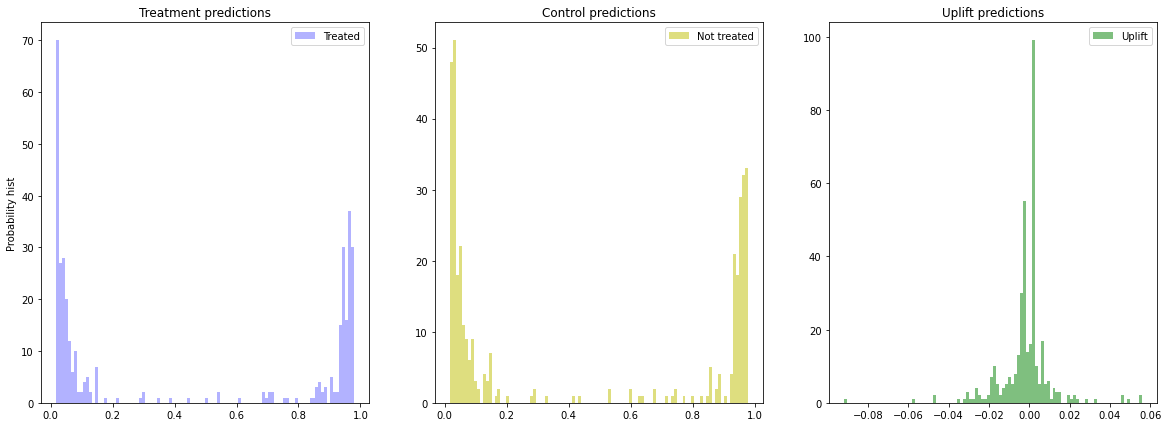

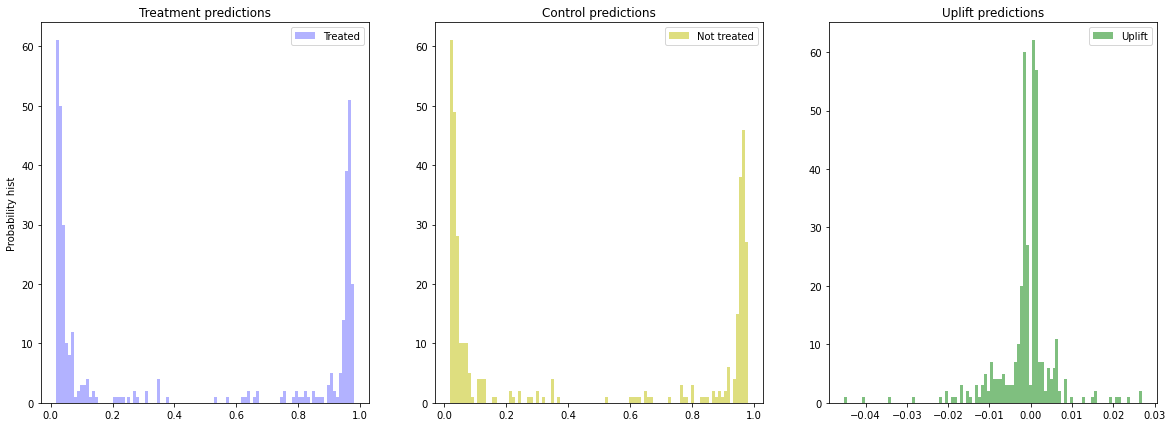

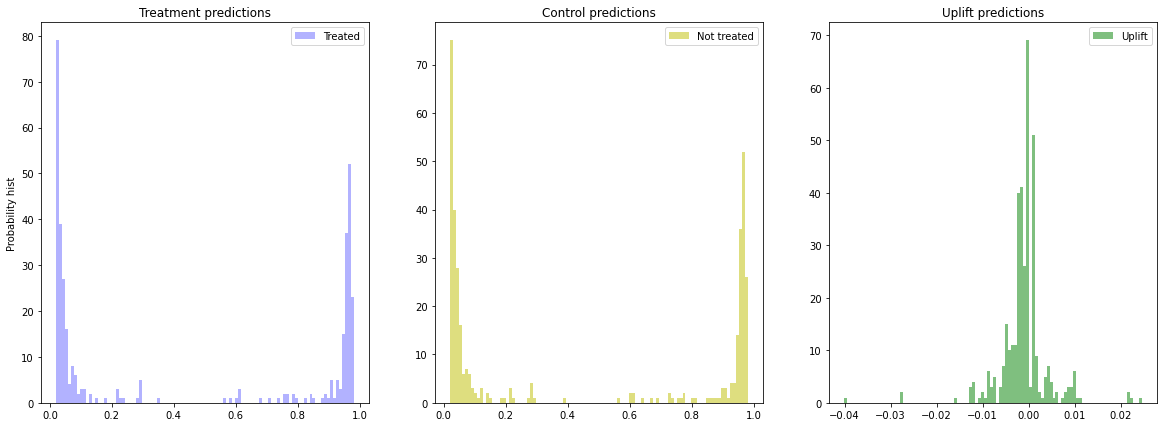

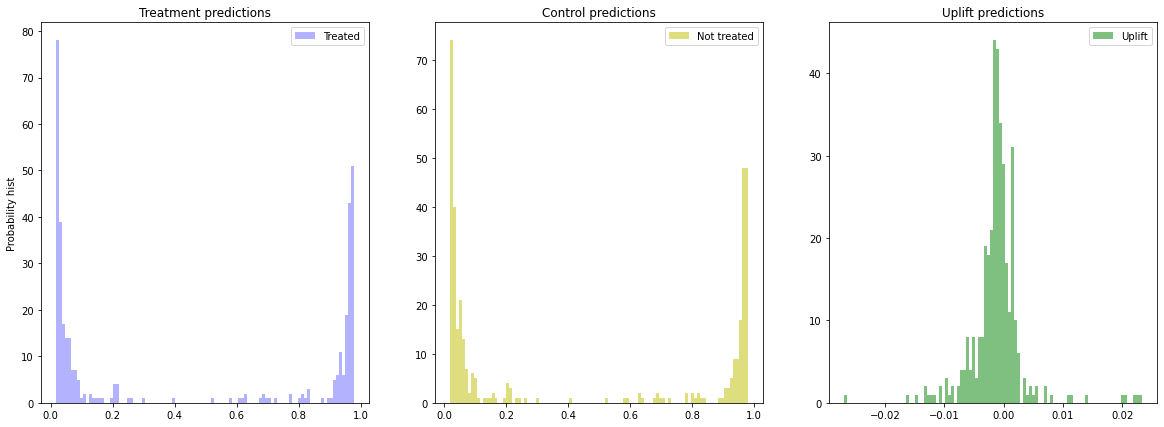

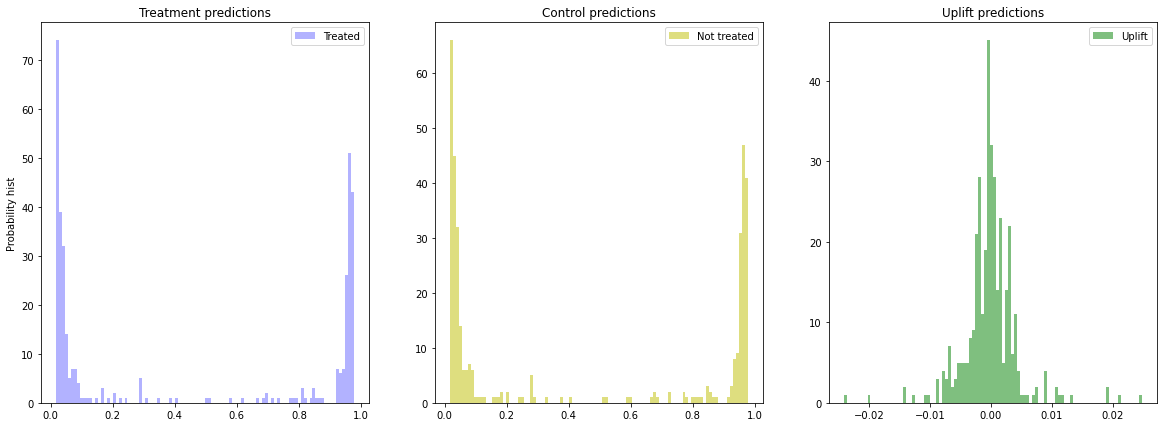

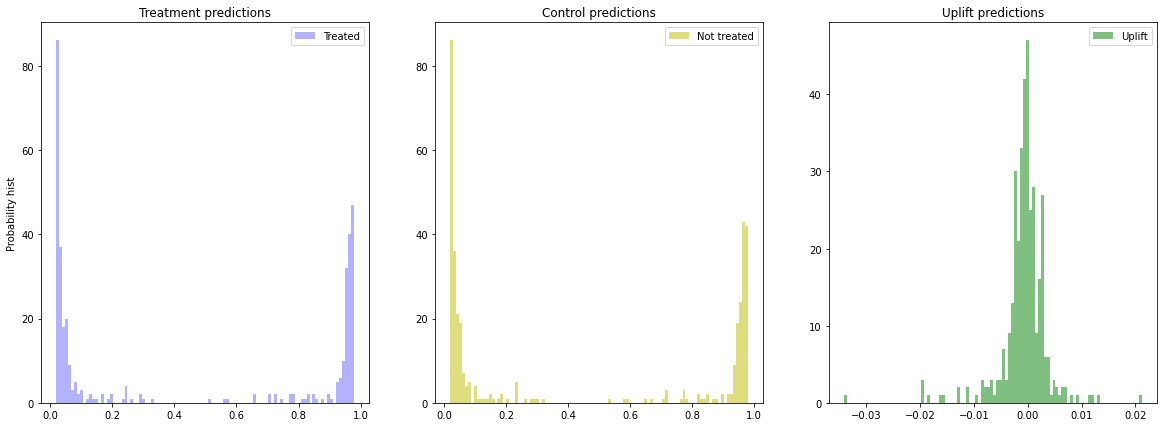

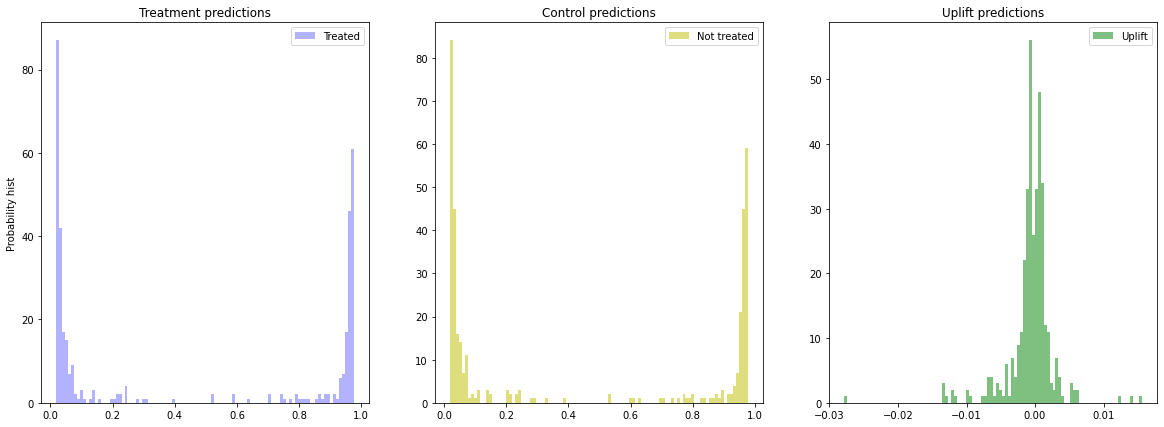

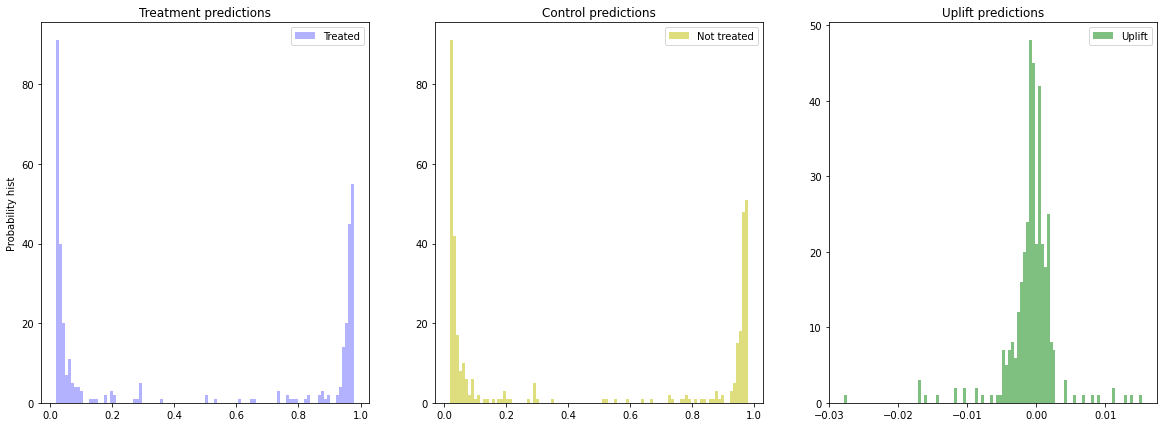

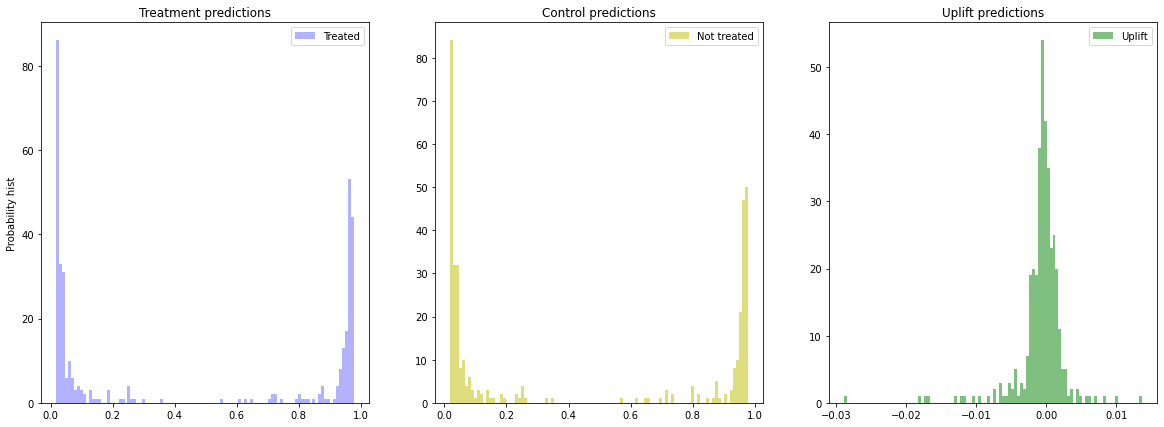

In [38]:
for i in range(10, 100, 10):
    sm = SoloModel(CatBoostClassifier(iterations=i, thread_count=2, random_state=42, silent=True))
    sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
    uplift_sm = sm.predict(X_val)
    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

    models_results['approach'].append('SoloModel')
    models_results['uplift@30%'].append(sm_score)

    # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
    sm_trmnt_preds = sm.trmnt_preds_

    # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
    sm_ctrl_preds = sm.ctrl_preds_

    # Отрисуем распределения вероятностей и их разность (uplift)
    plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Задание 3

Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_.

In [39]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

In [40]:
sm_fi

,feature_name,feature_score
0,skewness,35.524046
1,variance,26.710162
2,curtosis,17.573817
3,rms,12.536582
4,re,5.073599
5,entropy,2.304040
6,treatment,0.144676
7,new_old,0.085841
8,treatment_flg,0.047238


#### Задание 4

Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе

In [41]:
models_results = {
    'iteration': [],
    'approach': [],
    'uplift@30%': [],
    'rocauc': [],
    'logloss': [],
    'f1': [],
}

In [42]:
for i in range(1, 101):
    sm = SoloModel(CatBoostClassifier(iterations=i, thread_count=2, random_state=42, silent=True))
    sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
    uplift_sm = sm.predict(X_val)
    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
    y_pred = [(1 if i > 0 else 0) for i in uplift_sm]

    models_results['iteration'].append(i)
    models_results['approach'].append('SoloModel')
    models_results['uplift@30%'].append(sm_score)
    models_results['rocauc'].append(roc_auc_score(y_val, y_pred))
    models_results['logloss'].append(log_loss(y_val, y_pred))
    models_results['f1'].append(f1_score(y_val, y_pred))

In [43]:
pd.DataFrame(models_results)

,iteration,approach,uplift@30%,rocauc,logloss,f1
0,1,SoloModel,0.008081,0.664229,11.638222,0.633136
1,2,SoloModel,0.006734,0.664229,11.638222,0.633136
2,3,SoloModel,0.006734,0.664229,11.638222,0.633136
3,4,SoloModel,0.006734,0.664229,11.638222,0.633136
4,5,SoloModel,0.007071,0.664229,11.638222,0.633136
...,...,...,...,...,...,...
95,96,SoloModel,-0.117508,0.652192,11.638188,0.594771
96,97,SoloModel,-0.099327,0.652192,11.638188,0.594771
97,98,SoloModel,-0.117508,0.652192,11.638188,0.594771
98,99,SoloModel,-0.006397,0.663537,11.075034,0.595890
